<a href="https://colab.research.google.com/github/zuxinrui/NLP_utwente2019/blob/master/project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings ("ignore")
import pandas as pd
from tqdm import tqdm
import time
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
#from wordcloud import Wordcloud
import torch.nn as nn
import re
import os 
from sqlalchemy import create_engine # database connection 
import datetime as dt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.linear_model import SGDClassifier 
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score 
from sklearn import svm
from sklearn.linear_model import LogisticRegression 
from skmultilearn.adapt import mlknn 
from skmultilearn.problem_transform import ClassifierChain 
from skmultilearn.problem_transform import BinaryRelevance 
from skmultilearn.problem_transform import LabelPowerset 
from sklearn.naive_bayes import GaussianNB 
from datetime import datetime
from ast import literal_eval
import glob
from collections import Counter
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline

In [3]:
!pip install scikit-multilearn
# 首先执行这句，安装模块

     |████████████████████████████████| 92kB 3.4MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
DATA_PATH = '/content/drive/My Drive/'
data = pd.read_csv(DATA_PATH + 'mpst_full_data.csv')
data.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split',
       'synopsis_source'],
      dtype='object')

In [0]:
def trans_to_array(y):
    y_new=[]
    for label in y:
    #     print(i)
        this = []
        word =''
        for m in label:
            if m != ',':
                if m !=' ':
                    word += m
            else:
                this.append(word)
                word = ''
        this.append(word)
        y_new.append(this)
    return y_new

tags_new = trans_to_array(data['tags'])
print(len(tags_new))
data['tags'] = tags_new

In [0]:
CorpusData = data[['tags', 'title', 'plot_synopsis']]
print(CorpusData)

In [44]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
print(CorpusData['tags'][5])
tag_dtm = vectorizer.fit_transform(m for x in CorpusData['tags'] for m in x)
print("Number of data points :",tag_dtm.shape[0])
print("Number of unique tags :",tag_dtm.shape[1])
print(tag_dtm)

['romantic', 'queer', 'flashback']
Number of data points : 44206
Number of unique tags : 71
  (0, 20)	1
  (1, 36)	1
  (2, 30)	1
  (3, 43)	1
  (4, 7)	1
  (5, 68)	1
  (6, 57)	1
  (7, 39)	1
  (8, 57)	1
  (9, 63)	1
  (10, 27)	1
  (11, 19)	1
  (12, 43)	1
  (13, 24)	1
  (14, 20)	1
  (15, 68)	1
  (16, 7)	1
  (17, 1)	1
  (18, 57)	1
  (19, 56)	1
  (20, 58)	1
  (21, 57)	1
  (22, 54)	1
  (23, 28)	1
  (24, 30)	1
  :	:
  (44181, 68)	1
  (44182, 57)	1
  (44183, 34)	1
  (44184, 1)	1
  (44185, 65)	1
  (44186, 45)	1
  (44187, 68)	1
  (44188, 67)	1
  (44189, 56)	1
  (44190, 61)	1
  (44191, 10)	1
  (44192, 57)	1
  (44193, 45)	1
  (44194, 55)	1
  (44195, 43)	1
  (44196, 68)	1
  (44197, 7)	1
  (44198, 65)	1
  (44199, 17)	1
  (44200, 43)	1
  (44201, 29)	1
  (44202, 68)	1
  (44203, 6)	1
  (44204, 43)	1
  (44205, 14)	1


In [45]:
# 查看现有的tags
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:30])

Some of the tags we have : ['absurd', 'action', 'adultcomedy', 'allegory', 'alternatehistory', 'alternatereality', 'antiwar', 'atmospheric', 'autobiographical', 'avantgarde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christianfilm', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'goodversusevil']


In [48]:
#store the document term matrix in a dictionaty
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags,freqs))
print(result)

{'absurd': 270, 'action': 664, 'adultcomedy': 128, 'allegory': 139, 'alternatehistory': 102, 'alternatereality': 205, 'antiwar': 118, 'atmospheric': 396, 'autobiographical': 44, 'avantgarde': 220, 'blaxploitation': 74, 'bleak': 211, 'boring': 525, 'brainwashing': 107, 'christianfilm': 42, 'claustrophobic': 84, 'clever': 87, 'comedy': 1859, 'comic': 114, 'cruelty': 442, 'cult': 2647, 'cute': 197, 'dark': 405, 'depressing': 205, 'dramatic': 412, 'entertaining': 749, 'fantasy': 564, 'feel-good': 76, 'flashback': 2937, 'goodversusevil': 875, 'gothic': 441, 'grindhousefilm': 66, 'haunting': 151, 'historical': 272, 'historicalfiction': 143, 'homemovie': 153, 'horror': 486, 'humor': 822, 'insanity': 636, 'inspiring': 118, 'intrigue': 168, 'magicalrealism': 54, 'melodrama': 457, 'murder': 5782, 'mystery': 519, 'neonoir': 745, 'nonfiction': 37, 'paranormal': 546, 'philosophical': 228, 'plottwist': 205, 'pornographic': 163, 'prank': 255, 'psychedelic': 1897, 'psychological': 289, 'queer': 98, 'r

In [50]:
#Saving this dictionary to csv files 注意不要重复保存
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv','w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key,value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags','Counts'])
tag_df.head()

,Tags,Counts
0,absurd,270
1,action,664
2,adultcomedy,128
3,allegory,139
4,alternatehistory,102


In [51]:
# 将标签排序，显示结果
tag_df_sorted = tag_df.sort_values(['Counts'],ascending=False)
tag_counts = tag_df_sorted['Counts'].values
print(tag_counts, tag_df_sorted)

[5782 4426 2937 2906 2647 2468 1897 1859 1086  875  822  816  749  745
  664  652  636  597  564  546  525  519  486  457  442  441  412  405
  396  364  309  289  272  270  255  233  228  220  211  205  205  205
  204  197  190  168  163  153  151  143  139  128  120  118  118  114
  107  102   98   87   84   79   76   74   73   66   54   54   44   42
   37]                  Tags  Counts
43             murder    5782
68           violence    4426
28          flashback    2937
57           romantic    2906
20               cult    2647
56            revenge    2468
52        psychedelic    1897
17             comedy    1859
65        suspenseful    1086
29     goodversusevil     875
37              humor     822
59             satire     816
25       entertaining     749
45            neonoir     745
1              action     664
58             sadist     652
38           insanity     636
67            tragedy     597
26            fantasy     564
47         paranormal     546
12      

In [52]:
#tag_df_sorted = FinalData['tags'].sort_values(['Counts'],ascending=False)
#tag_counts = tag_df_sorted['Counts'].values
#print(tag_counts, tag_df_sorted)

NameError: ignored

In [0]:
#CorpusData = data[['tags', 'title', 'plot_synopsis']]
#print(type(CorpusData['tags'][0]))
#i = 0
#for tag in tqdm(CorpusData['tags']):
#  CorpusData['tags'][i] = CorpusData['tags'][i].split(', ')
#  i += 1
#print(CorpusData['tags'][:10])

  0%|          | 1/14828 [00:00<25:22,  9.74it/s]

<class 'str'>


100%|██████████| 14828/14828 [26:14<00:00,  9.18it/s]

0          [cult, horror, gothic, murder, atmospheric]
1                                           [violence]
2                                           [romantic]
3             [inspiring, romantic, stupid, feel-good]
4    [cruelty, murder, dramatic, cult, violence, at...
5                         [romantic, queer, flashback]
6    [gothic, cruelty, violence, cult, revenge, sad...
7    [mystery, suspenseful, action, murder, flashback]
8                                           [violence]
9     [revenge, neo noir, murder, violence, flashback]
Name: tags, dtype: object


In [53]:
# 建立需要去除的标签列表
genresToRemove = []
for key, value in result.items():
  if value < 500:
    genresToRemove.append(key)
print(len(genresToRemove)) # 需要去除的标签个数
print(CorpusData['tags'][:10])
# 在数据集中去除标签
CorpusData['tags'] = CorpusData['tags'].apply(
    lambda genreList: [genre for genre in genreList if genre not in genresToRemove]
)

49
0          [cult, horror, gothic, murder, atmospheric]
1                                           [violence]
2                                           [romantic]
3             [inspiring, romantic, stupid, feel-good]
4    [cruelty, murder, dramatic, cult, violence, at...
5                         [romantic, queer, flashback]
6    [gothic, cruelty, violence, cult, revenge, sad...
7    [mystery, suspenseful, action, murder, flashback]
8                                           [violence]
9      [revenge, neonoir, murder, violence, flashback]
Name: tags, dtype: object


In [54]:
CorpusData = CorpusData[CorpusData['tags'].map(lambda x: len(x)) > 0] # 将tag为零的数据删除
# print(len(CorpusData))
print(CorpusData)

# 接下来是对数据集的画图部分，与本项目关系不大，可以略过

                                                    tags  ...                                      plot_synopsis
0                                         [cult, murder]  ...  Note: this synopsis is for the orginal Italian...
1                                             [violence]  ...  Two thousand years ago, Nhagruul the Foul, a s...
2                                             [romantic]  ...  Matuschek's, a gift store in Budapest, is the ...
3                                             [romantic]  ...  Glenn Holland, not a morning person by anyone'...
4      [murder, cult, violence, action, romantic, rev...  ...  In May 1980, a Cuban man named Tony Montana (A...
5                                  [romantic, flashback]  ...  George Falconer (Colin Firth) approaches a car...
6                      [violence, cult, revenge, sadist]  ...  Baise-moi tells the story of Nadine and Manu w...
7      [mystery, suspenseful, action, murder, flashback]  ...  Kyle Pratt (Jodie Foster) is a pr

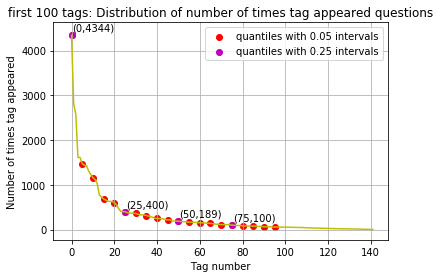

In [0]:
plt.plot(tag_counts,c='y')
plt.scatter(x = list(range(0,100,5)), y = tag_counts[0:100:5], c = 'r',label="quantiles with 0.05 intervals")
plt.scatter(x = list(range(0,100,25)), y = tag_counts[0:100:25], c = 'm',label="quantiles with 0.25 intervals")
# 对标签的分布进行整理，每隔5/25个显示一个点

for x,y in zip(list(range(0,100,25)),tag_counts[0:100:25]):
    plt.annotate(s="({},{})".format(x,y),xy=(x,y),xytext=(x+0.5,y+100))
# 画黄线

plt.title("first 100 tags: Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [0]:
tag_quest_count = tag_dtm.sum(axis=1).tolist() # 每条数据的标签数
# print(tag_quest_count)
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 14828 datapoints.
[5, 1, 1, 4, 10]


In [0]:
print("Maximum number of tags per question: %d"%max(tag_quest_count))
print("Minimum number of tags per question: %d"%min(tag_quest_count))
print("Average number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 25
Minimum number of tags per question: 1
Average number of tags per question: 2.981252


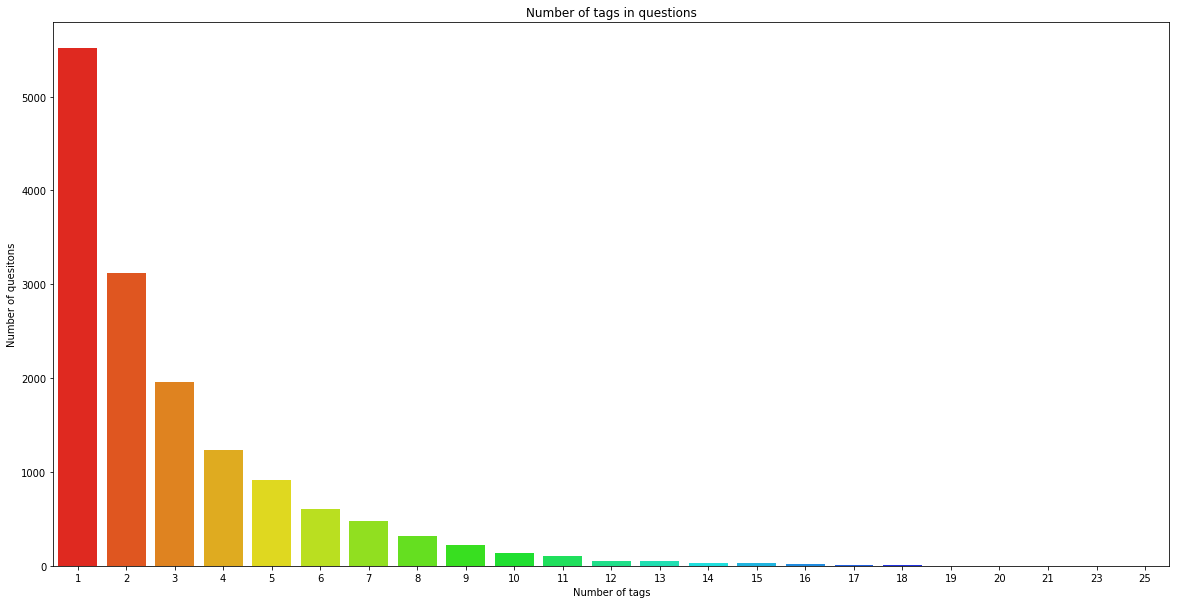

In [0]:
fig = plt.figure(figsize=(20,10))
sns.countplot(tag_quest_count,palette='gist_rainbow')
plt.title("Number of tags in questions")
plt.xlabel("Number of tags")
plt.ylabel("Number of quesitons")
plt.show()
# 数据标签数的分布

<Figure size 1440x720 with 0 Axes>

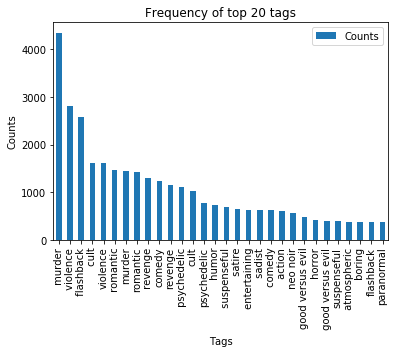

In [0]:
i= np.arange(30)
fig = plt.figure(figsize=(20,10))
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.xticks(i,tag_df_sorted['Tags'])
plt.show()
# 前20个最普遍的标签

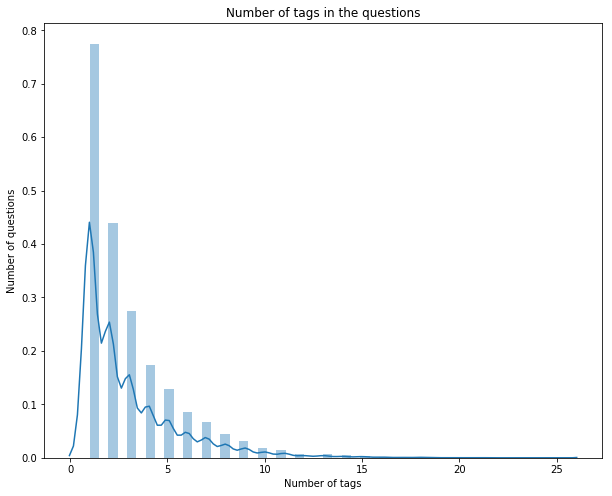

In [0]:
plt.figure(figsize=(10,8))
plt.subplot()
sns.distplot(tag_quest_count)
plt.title("Number of tags in the questions")
plt.xlabel("Number of tags")
plt.ylabel("Number of questions")
plt.show()

In [0]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dub.db')
    clean_data = pd.read_sql_query("""SELECT * FROM no_dub_train""",con)
    con.close()
    #drop unwanted column.
    clean_data.drop(clean_data.index[0], inplace=True)
    clean_data.head()
    print("Time taken to run this cell :",datetime.now()-start)
else:
    print("Run the above cells to generate train_no_dup.db file")
data.drop(['imdb_id'],axis=1)

Run the above cells to generate train_no_dup.db file


,title,plot_synopsis,tags,split,synopsis_source
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb
5,A Single Man,George Falconer (Colin Firth) approaches a car...,"romantic, queer, flashback",val,imdb
6,Baise-moi,Baise-moi tells the story of Nadine and Manu w...,"gothic, cruelty, violence, cult, revenge, sadist",train,wikipedia
7,Flightplan,Kyle Pratt (Jodie Foster) is a propulsion engi...,"mystery, suspenseful, action, murder, flashback",train,imdb
8,Little Caesar,Small-time Italian-American criminals Caesar E...,violence,train,imdb
9,Savages,The movie begins with a video being shot of me...,"revenge, neo noir, murder, violence, flashback",train,imdb


In [55]:
# 除去前面画图部分，本项目的数据从这里开始处理

import re
# 文本tokenize
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
from bs4 import BeautifulSoup
from tqdm import tqdm #printing the status bar
preprocessed_reviews = []
for sentance in tqdm(CorpusData['plot_synopsis'].values):
    sentance = re.sub(r"http\S+","",sentance) # 删去http网址
    sentance = BeautifulSoup(sentance,'lxml').get_text() # 转换格式
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance) # 正则表达式！删去非字母符号
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

CorpusData['preprocess_data'] = preprocessed_reviews

100%|██████████| 13715/13715 [00:20<00:00, 673.54it/s]


In [56]:
print(type(CorpusData))
FinalData = CorpusData.reset_index()
FinalData = FinalData.drop('index', 1)
print(CorpusData)
print(FinalData)
# 修改数据的索引，变成连续自然数

<class 'pandas.core.frame.DataFrame'>
                                                    tags  ...                                    preprocess_data
0                                         [cult, murder]  ...  note synopsis orginal italian release segments...
1                                             [violence]  ...  two thousand years ago nhagruul foul sorcerer ...
2                                             [romantic]  ...  matuschek gift store budapest workplace alfred...
3                                             [romantic]  ...  glenn holland morning person anyone standards ...
4      [murder, cult, violence, action, romantic, rev...  ...  may cuban man named tony montana al pacino cla...
5                                  [romantic, flashback]  ...  george falconer colin firth approaches car acc...
6                      [violence, cult, revenge, sadist]  ...  baise moi tells story nadine manu go violent s...
7      [mystery, suspenseful, action, murder, flashback]  

In [57]:
# 最终的数据格式(X, y)
X = FinalData['preprocess_data']
y = FinalData['tags']
print(X.shape,y.shape)

(13715,) (13715,)


In [58]:
# 加载GloVe向量集，定义词到向量的转换函数
gloveEmbed = pd.read_csv(DATA_PATH + "glove.6B.50d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
# Define a functions to return word embedding as an array from token input.

def GloveVec(w):
  return gloveEmbed.loc[w].as_matrix()

# Check if it works
GloveVec('amazing')

array([-0.013117 ,  0.42197  , -0.26317  ,  0.34218  ,  0.99922  ,
       -0.21694  , -0.08976  , -0.19715  ,  0.32896  ,  0.95953  ,
       -0.4646   ,  0.10258  , -0.53764  , -0.0594   ,  0.6885   ,
       -0.72556  ,  0.57731  ,  0.39767  , -0.98963  , -0.48204  ,
       -0.40209  ,  0.90999  ,  0.14151  , -0.64745  ,  1.5189   ,
       -0.06979  , -1.6931   , -0.07218  ,  0.8199   , -0.59112  ,
        1.8197   ,  0.62039  ,  0.4555   , -0.19383  , -0.12375  ,
        0.44672  ,  0.0091402,  0.58273  , -0.27283  , -0.65483  ,
       -0.19586  , -0.28047  , -0.52825  , -0.22604  , -0.066117 ,
        0.2579   ,  0.50016  , -0.12294  , -0.2093   ,  0.66911  ])

In [59]:
# 将文本向量化处理，需要较长时间，句长55，词向量50维的情况下需要转换1小时300分钟左右
sentence_len = 55
CorpusData_num = 13715
# 如果用100维或者300维向量的话，50改成相应的维度
xVar = np.zeros((CorpusData_num, sentence_len, 50))
dataAdded = 0

# Loop through data
for i in tqdm(range(CorpusData_num)):
    words = X[i].split()
    sentenceID = 0
    for tok in words:  
        # The mean length of the sentence prior to removing some
        # genres was just above 20. I will set it to 20 here because
        # I do not want to pad too many sentences.
        if sentenceID >= sentence_len:
            break
        # Remove stop words and tokens with 2 characters or less (pretty much also a stop word)
        # if len(tok) < 2 or tok in stopList:
            # continue
        # 这句话由于之前已经tokenize所以省略掉！！ 
        else: 
            if tok in gloveEmbed.index:         
                xVar[dataAdded,sentenceID,:] = GloveVec(tok)
                sentenceID += 1
    dataAdded += 1
    #if dataAdded % 100 == 0:
        #print("Parsed {} datapoints, \t Time: {}".format(dataAdded, datetime.now()))

100%|██████████| 13715/13715 [1:29:29<00:00,  2.51it/s]


In [0]:
# 由于转换过程较长，向量集保存在云盘中随用随取
# 注意保存文件的名称，按照转换的维度命名
with open(DATA_PATH+"xPointsEmbedded_55words_22tags.pickle", 'wb') as handle:
    pickle.dump(xVar, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATA_PATH+"yPointsEmbedded_22tags.pickle", 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# 之后的数据加载可从这里开始，在前面先链接谷歌云盘，然后直接跳到这一步
DATA_PATH = '/content/drive/My Drive/'
with open(DATA_PATH+"xPointsEmbedded_55words_22tags.pickle", 'rb') as handle:
    xVar = pickle.load(handle)
    
with open(DATA_PATH+"yPointsEmbedded_22tags.pickle", 'rb') as handle:
    y = pickle.load(handle)
# 加载已经向量化的文本数据及其标签
# 查看X, y的形状
print(xVar.shape)
print(y.shape)

(13715, 55, 50)
(13715,)


In [7]:
# 加载pytorch，将y从标签格式转换为向量格式，并分割数据为train和test
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F

y_list = list(y)
multilabel_binarizer = MultiLabelBinarizer()
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary = 'true', max_features = 15)
#y_train_vect = vectorizer.fit_transform(y_train)
#y_test_vect = vectorizer.fit_transform(y_test)
multilabel_binarizer.fit(y_list)
y_vec = multilabel_binarizer.transform(y_list)
X_train, X_test, y_train, y_test = train_test_split(xVar, y_vec, test_size=0.2, random_state = 42)
#print(type(y_test_vect)) # 行优先的稀疏矩阵数据类型!!
# 测试一下标签处理结果：
print(y_test[19])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]


In [0]:
# 超参设定
input_size = 50
hidden_size = 128
hidden_size_2 = 512
hidden_size_3 = 256
hidden_size_4 = 64
num_classes = 22
num_epochs = 100
batch_size = 32
learning_rate = 2e-4
sentence_len = 55

In [82]:
#aa = torch.randn(3,4)
#print(aa)
#aa[1, :2] = 1
#print(aa[1, :2])
#print(aa)

tensor([[ 1.2977, -0.5789, -0.3813, -1.4258],
        [ 1.6694,  0.3926,  1.6059, -1.4089],
        [-0.3390, -0.9777,  0.9659, -0.1867]])
tensor([1., 1.])
tensor([[ 1.2977, -0.5789, -0.3813, -1.4258],
        [ 1.0000,  1.0000,  1.6059, -1.4089],
        [-0.3390, -0.9777,  0.9659, -0.1867]])


In [0]:
# 加载数据(x,y)到特定的batch中，并且转换为pytorch类型的tensor，定义多种计算准确率的方法
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import f1_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

def low_accuracy(model, datasetLoader, batch_size=32):
  
    total = 0
    correct = 0
    
    for x_batch, y_batch in datasetLoader:
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        nBatch, _, _ = x_batch.shape
        
        # Update the total count
        total += nBatch
        
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        # print(outputs)
        # print(outputs.shape)
        #.  outputs_tensor = torch.zeros(batch_size, num_classes)
        # print(outputs[22,:])
        #outputs_list = outputs.tolist()
        # 因为最后剩一个batch是22个元素，所以会报错！！
        try:
            
            _, index = torch.sort(outputs, 1)
            for i in range(batch_size):
              if y_batch[i, index[i, -2]].item() == 1:
                correct += 0.5
              if y_batch[i, index[i, -1]].item() == 1:
                correct += 0.5

                #for j in range(num_classes):
                    #if outputs[i, j] >= -2:
                        #outputs_tensor[i, j] = 1
        #outputs_list = torch.from_numpy(np.array(outputs_list))
        
                    
        # _, predictions = torch.max(outputs, 1) torch.max函数，第二个输入是维度，这里是一维，然后输出最大值和其索引
        # print(predictions)
        # print(y_batch)
        # correct += (outputs_tensor == y_batch).sum() # 这个计算正确的函数有大问题，维度没匹配
                        #if y_batch[i, j] == 1:
                            #correct += 1 # 这里是导致准确率大于1的原因！
        except:
            continue
        
    return float(correct) / total


def exact_accuracy(model, datasetLoader, batch_size=32):
    total = 0
    correct = 0
    for x_batch, y_batch in datasetLoader:    
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        nBatch, _, _ = x_batch.shape
        # Update the total count
        total += nBatch
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        try:
            _, index = torch.sort(outputs, 1)
            for i in range(batch_size):
              if y_batch[i, index[i, -1]].item() == 1 & y_batch[i, index[i, -2]].item() == 1:
                correct += 1
        except:
            continue
        
    return float(correct) / total


def probability_accuracy(model, datasetLoader, batch_size=32):
    total = 0
    correct = 0
    sum = 0
    f1_score_micro = []
    f1_score_macro = []
    f1_score_weighted = []
    for x_batch, y_batch in datasetLoader:    
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        nBatch, _, _ = x_batch.shape
        # Update the total count
        total += nBatch
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        prediction = torch.zeros(batch_size, num_classes)
        try:
            _, index = torch.sort(outputs, 1, descending=True)
            for i in range(batch_size):
              for j in range(num_classes):
                sum += outputs[i, index[i, j]].item()
                if sum >= 0.8:
                  prediction[i, index[i, :j+1]] = 1
                  sum = 0
              for k in range(num_classes):
                if prediction[i, k].item() == 1 & y_batch[i, k].item() == 1:
                  correct += 0.5
            f1_score_micro.append(f1_score(y_batch, prediction, average='micro'))
            f1_score_macro.append(f1_score(y_batch, prediction, average='macro'))
            f1_score_weighted.append(f1_score(y_batch, prediction, average='weighted'))
            
        except:
            continue
        
    return [float(correct) / total, float(np.sum(f1_score_micro)) / len(f1_score_micro), float(np.sum(f1_score_macro)) / len(f1_score_macro), float(np.sum(f1_score_weighted)) / len(f1_score_weighted)]


def single_accuracy(model, datasetLoader, batch_size=32):
    total = 0
    correct = 0
    for x_batch, y_batch in datasetLoader:    
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        nBatch, _, _ = x_batch.shape
        # Update the total count
        total += nBatch
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        # 单分类直接输出每行的最大值
        try:
            count = 0
            for i in outputs:
              _, index = i.max(dim=0)
              if y_batch[count][index] == 1:
                correct += 1
              count += 1
        except:
            continue
        
    return float(correct) / total

def f1_accuracy(model, datasetLoader, batch_size=32):
    total = 0
    correct = 0
    batch_num = 0
    #del f1_score_micro
    #del f1_score_macro
    #del f1_score_weighted
    f1_score_micro = []
    f1_score_macro = []
    f1_score_weighted = []
    for x_batch, y_batch in datasetLoader:    
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        nBatch, _, _ = x_batch.shape
        # Update the total count
        total += nBatch
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        # 建立预测的01向量
        prediction = torch.zeros(batch_size, num_classes)
        try:
          _, index = torch.sort(outputs, 1)
          for i in range(batch_size):
            prediction[i, index[i, -1]] = 1
            prediction[i, index[i, -2]] = 1
          f1_score_micro.append(f1_score(y_batch, prediction, average='micro'))
          f1_score_macro.append(f1_score(y_batch, prediction, average='macro'))
          f1_score_weighted.append(f1_score(y_batch, prediction, average='weighted'))

        except:
          continue
    return [float(np.sum(f1_score_micro)) / len(f1_score_micro), float(np.sum(f1_score_macro)) / len(f1_score_macro), float(np.sum(f1_score_weighted)) / len(f1_score_weighted)]
    
def f1_accuracy_single(model, datasetLoader, batch_size=32):
    total = 0
    correct = 0
    batch_num = 0
    #del f1_score_micro
    #del f1_score_macro
    #del f1_score_weighted
    f1_score_micro = []
    f1_score_macro = []
    f1_score_weighted = []
    for x_batch, y_batch in datasetLoader:    
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        nBatch, _, _ = x_batch.shape
        # Update the total count
        total += nBatch
        # Calculate how many were correct
        outputs = model(x_batch) # 这是输出的预测结果
        # 建立预测的01向量
        prediction = torch.zeros(batch_size, num_classes)
        try:
          _, index = torch.sort(outputs, 1)
          for i in range(batch_size):
            prediction[i, index[i, -1]] = 1
          
          f1_score_micro.append(f1_score(y_batch, prediction, average='micro'))
          f1_score_macro.append(f1_score(y_batch, prediction, average='macro'))
          f1_score_weighted.append(f1_score(y_batch, prediction, average='weighted'))
          # 1、注意循环的问题！不要套在最里面！
          # 2、注意index是二维的！在第一层循环上要标注[i]

        except:
          continue
    return [float(np.sum(f1_score_micro)) / len(f1_score_micro), float(np.sum(f1_score_macro)) / len(f1_score_macro), float(np.sum(f1_score_weighted)) / len(f1_score_weighted)]

  
def loadData(X_train, y_train, X_test, y_test):
  
    x_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()

    x_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()

    train_dataset = CustomDataset(x_train_tensor, y_train_tensor)
    test_dataset = CustomDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

In [0]:
# 几种不同的RNN模型，此处可进行多步优化，注意超参在前面修改
# Fully connected neural network with one hidden layer
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):

        batch_size = x.size(0)
      
        x = x.view(sentence_len, batch_size, -1) # [Timesteps, batch_size, features]重新组织了一下输入的形状

        out, _ = self.lstm(x)        
        out = out[-1].view(batch_size, -1) # Only take last input
  
        out = self.relu(out)
        out = self.fc1(out)
        out = F.softmax(out)
        return out


class LSTM_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM_2, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size_3)
        self.lstm2 = nn.LSTM(hidden_size_3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):

        batch_size = x.size(0)
      
        x = x.view(sentence_len, batch_size, -1) # [Timesteps, batch_size, features]重新组织了一下输入的形状

        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)        
        out = out[-1].view(batch_size, -1) # Only take last input
  
        out = self.relu(out)
        out = self.fc1(out)
        out = F.softmax(out)
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU, self).__init__()
        
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):

        batch_size = x.size(0)
      
        x = x.view(sentence_len, batch_size, -1) # [Timesteps, batch_size, features]重新组织了一下输入的形状

        out, _ = self.gru(x)        
        out = out[-1].view(batch_size, -1) # Only take last input
  
        out = self.relu(out)
        out = self.fc1(out)
        out = F.softmax(out)
        return out
# 模型的结构需要谨慎对待，lstm的输出不止一个，看其他例子

In [0]:
# 迭代训练，迭代步数在超参处可以设置，每迭代一步同时计算在训练集和测试集上的准确率和其他评估标准
# 可以简易更换所用的训练模型，也可以简易更换分类器和评估方法
train_loader, test_loader = loadData(X_train, y_train, X_test, y_test)
print('Number of Batches:', len(train_loader))
# Training Loop:
total_step = len(train_loader)

train_acc = []
test_acc = []
loss_hist = []

# Initialise the model
# 在这里更换模型
model = LSTM(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
# 在这里更换损失函数和优化方法
criterion = nn.MultiLabelSoftMarginLoss() # 损失函数是针对于单类别的，需要修改，查看torch有无对应的集成方法
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 迭代过程
for epoch in range(num_epochs):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
    
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize 优化的步骤就是后向传递，优化的方法是随机梯度下降
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 在这里更换分类器和评估方法
    print ('Epoch [{}/{}], Loss: {:.3f}, Train Acc: {}, Test Acc: {}' 
       .format(epoch+1, num_epochs, loss.item(), 
               probability_accuracy(model, train_loader, batch_size), probability_accuracy(model, test_loader, batch_size)))
        
    train_acc.append(probability_accuracy(model, train_loader, batch_size))
    test_acc.append(probability_accuracy(model, test_loader, batch_size))
    loss_hist.append(loss.item())

343
Epoch [1/100], Loss: 0.711, Train Acc: [0.6092325920524972, 0.1563044293050217, 0.13922010036195, 0.20792948305712983], Test Acc: [0.6288734961720743, 0.15987634795098093, 0.14541804322929663, 0.21441323499960904]
Epoch [2/100], Loss: 0.711, Train Acc: [0.6142453518045935, 0.1576032406461016, 0.14041162325654052, 0.2114796004855226], Test Acc: [0.6332482683193583, 0.16101058444245164, 0.14618010373774315, 0.21690113138310407]
Epoch [3/100], Loss: 0.711, Train Acc: [0.6198505286183011, 0.1590486333914492, 0.14154487396470872, 0.21567362726442993], Test Acc: [0.6376230404666423, 0.1621384085394184, 0.14682175067293274, 0.22019334173154595]
Epoch [4/100], Loss: 0.711, Train Acc: [0.6259114108640175, 0.16061011680323087, 0.14288814719452297, 0.22024908264021908], Test Acc: [0.6434560699963544, 0.16362862295100838, 0.1480094330138487, 0.22449877483021882]
Epoch [5/100], Loss: 0.711, Train Acc: [0.6306507473569085, 0.16184209192322171, 0.14373051934180386, 0.22373263412410987], Test Acc:

In [0]:
# 这三块代码负责存储不同模型和方法算出的结果，以便后续画图，只需运行对应的模块即可
train_acc_plot = train_acc
test_acc_plot = test_acc
loss_hist_plot = loss_hist

In [0]:
train_acc_gru_plot = train_acc
test_acc_gru_plot = test_acc
loss_hist_gru_plot = loss_hist

In [0]:
train_acc_single_plot = train_acc
test_acc_single_plot = test_acc
loss_hist_single_plot = loss_hist

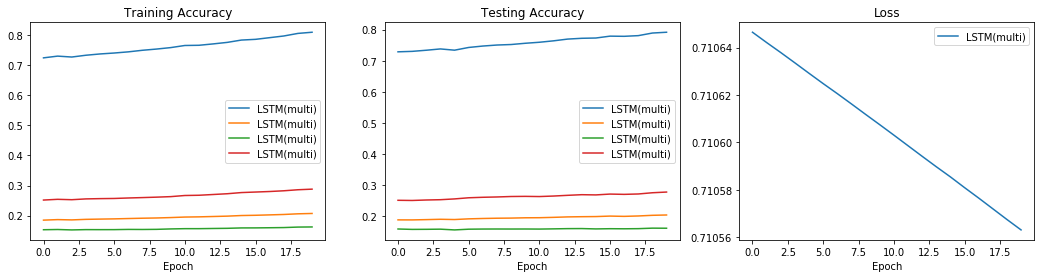

In [17]:
# 对结果进行画图
x_range = [i for i in range(0,num_epochs)]

plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.plot(x_range,train_acc_plot[:,0],label=['LSTM(multi)'])
#plt.plot(x_range,train_acc_gru_plot, label='GRU(multi)')
#plt.plot(x_range,train_acc_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1,4,2)
plt.plot(x_range,test_acc_plot, label=['accuracy', 'F1-score(micro)', 'F1-score(macro)', 'F1-score(weighted)'])
#plt.plot(x_range,test_acc_gru_plot, label='GRU(multi)')
#plt.plot(x_range,test_acc_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Testing Accuracy')
plt.legend()

plt.subplot(1,4,3)
plt.plot(x_range,loss_hist_plot, label=['accuracy', 'F1-score(micro)', 'F1-score(macro)', 'F1-score(weighted)'])
#plt.plot(x_range,loss_hist_gru_plot, label='GRU(multi)')
#plt.plot(x_range,loss_hist_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

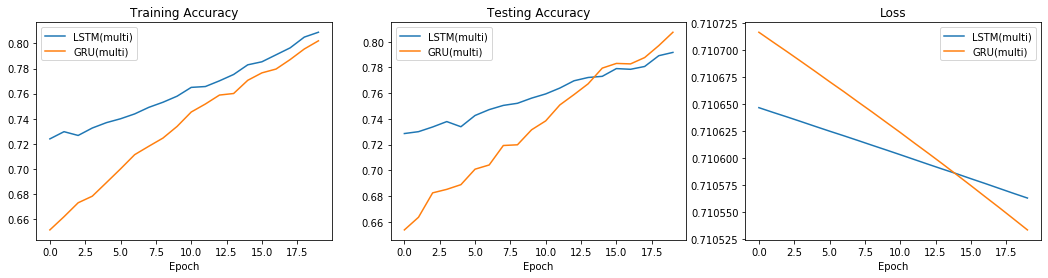

In [34]:
# 对结果画图
x_range = [i for i in range(0,num_epochs)]
plot1 = []
plot2 = []
plot3 = []
plot4 = []
plot5 = []
plot6 = []
for i in range(num_epochs):
  plot1.append(train_acc_plot[i][0])
  plot2.append(train_acc_gru_plot[i][0])
  plot3.append(test_acc_plot[i][0])
  plot4.append(test_acc_gru_plot[i][0])


plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(x_range,plot1,label='LSTM(multi)')
plt.plot(x_range,plot2, label='GRU(multi)')
#plt.plot(x_range,train_acc_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_range,plot3, label='LSTM(multi)')
plt.plot(x_range,plot4, label='GRU(multi)')
#plt.plot(x_range,test_acc_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Testing Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_range,loss_hist_plot, label='LSTM(multi)')
plt.plot(x_range,loss_hist_gru_plot, label='GRU(multi)')
#plt.plot(x_range,loss_hist_single_plot, label='LSTM(single)')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

In [33]:
# 最终的结果
print(train_acc_plot[num_epochs-1])
print(test_acc_plot[num_epochs-1])
print(train_acc_gru_plot[num_epochs-1])
print(test_acc_gru_plot[num_epochs-1])

[0.8089227123587314, 0.2071335901195308, 0.16237198800892594, 0.28787885702465743]
[0.7916514764855997, 0.20291641997835716, 0.16026144643915416, 0.27680596800001944]
[0.8020871308786001, 0.21119585909795613, 0.16815779809138034, 0.3133186822900792]
[0.8073277433467007, 0.21327045952484416, 0.1722151654630425, 0.31291233330721757]


In [0]:
# playground
print(outputs)
print(outputs[4,5])
#print(y_batch)
#arr = np.array([1,2,3,3])
#print(arr[2])
qwe = 0
_, aaa = torch.sort(outputs, 1)
mask = torch.gt(aaa,4)
for i in range(10):
  for j in range(7):
    if aaa[i,j].item() >= 5 & y_batch[i,j].item() == 1:
      qwe += 1
print(qwe)

tensor([[-1.0837, -0.8171, -0.0435, -1.0357, -0.8626, -0.8256, -0.3714],
        [-1.1018, -0.8121, -0.0587, -1.0361, -0.8734, -0.8283, -0.3652],
        [-1.0570, -0.7938, -0.0569, -1.0029, -0.8416, -0.7954, -0.3349],
        [-0.8676, -0.6308, -0.0892, -0.7866, -0.6673, -0.6335, -0.2398],
        [-0.9744, -0.7464, -0.0660, -0.8878, -0.8009, -0.6758, -0.3340],
        [-0.8054, -0.6225, -0.0828, -0.7529, -0.6983, -0.5715, -0.2469],
        [-0.9960, -0.7440, -0.0338, -0.8642, -0.7909, -0.6866, -0.2771],
        [-0.8977, -0.7404, -0.0510, -0.8522, -0.7460, -0.6314, -0.2879],
        [-1.1319, -0.8277, -0.0762, -1.0350, -0.8728, -0.8046, -0.3639],
        [-1.0280, -0.7823, -0.0718, -0.9718, -0.7774, -0.7503, -0.3393],
        [-1.0897, -0.8243, -0.0481, -1.0413, -0.8822, -0.8225, -0.3714],
        [-0.8635, -0.6400, -0.0741, -0.7889, -0.7141, -0.6048, -0.2844],
        [-0.8572, -0.6742, -0.0471, -0.8273, -0.7372, -0.6411, -0.3325],
        [-0.9815, -0.7188, -0.0267, -0.8671, -0.835

In [0]:
# playground
x = torch.arange(5)

print(x)

mask = torch.lt(x,3) # 小于

print(mask)

print(x[mask])

tensor([0, 1, 2, 3, 4])
tensor([ True,  True,  True, False, False])
tensor([0, 1, 2])


In [1]:
# playground
_, index = torch.sort(outputs, 1)
print(y_batch[4, index[3,5]].item())

NameError: ignored